In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import brute, minimize, fmin

import ROOT
from find_SN_dir import *

from tqdm import tqdm, trange
from multiprocessing import Pool
import multiprocessing as mp
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = [8,6]
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.visible'] = True

matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
# matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = 'Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial'
matplotlib.rcParams['font.serif'] = 'Tex Gyre Cursor, Courier, Courier New, Nimbus Mono, FreeMono'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif' 
matplotlib.rcParams['mathtext.default'] = 'regular'

In [21]:
pickle_path = "/media/linux_store/hep/data/pickles/event_pools.pkl"
ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_radiological_0201_pdf.dat", name="ES")
CC_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/CC_gvkm_radiological_0201_pdf.dat", name="CC")

/media/linux_store/hep/SN_pointing_scripts/make_PDF/find_SN_dir/find_SN_dir.py:134: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  energy_binning = np.loadtxt(f, max_rows=1)
/media/linux_store/hep/SN_pointing_scripts/make_PDF/find_SN_dir/find_SN_dir.py:135: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for 

### Load in event pool
either by reading the root files, or reading pickle files (faster)

In [3]:
# directory = "/media/linux_store/hep/data/SN_radio/SN_ana_radiological/"



# ES_event_pool = load_SN_file("/media/linux_store/hep/data/ES_gvkm/ES_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)
# CC_event_pool = load_SN_file("/media/linux_store/hep/data/CC_gvkm/CC_gvkm_radiological_0201.root",
#                              with_radio=True, return_nu_dir=True, show_progress=True)



In [ ]:
## Save pool as pickle
# import pickle
# with open(pickle_path, "wb") as f:
#     pickle.dump( [ES_event_pool, CC_event_pool], f)

In [22]:
## Read from pickle
import pickle
with open(pickle_path, "rb") as f:
    [ES_event_pool, CC_event_pool] = pickle.load(f)

In [11]:

# ES_numeric.pdf*=100

In [5]:
# with Pool(2) as p:
#     [ES_event_pool, CC_event_pool] = p.map(pre_rotate_events, [ES_event_pool, CC_event_pool])
# ES_event_pool = pre_rotate_events(ES_event_pool)
# CC_event_pool = pre_rotate_events(CC_event_pool)

100%|███████████████████████████████████████████████████████| 941962/941962 [00:26<00:00, 35981.00it/s]


In [23]:
def run_reco(a, b, es_exp=82, cc_exp=864, e_thresh = 5, sn_dir=None):
    confusion_matrix = np.array([[a, 0.5], [b, 0.5]])
    expected_counts = get_expected_counts([es_exp, cc_exp], confusion_matrix, channel_id_list=[0])
    SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                   synthetic=True, 
                                   with_radio=True, 
                                   expected_counts=expected_counts, 
                                   poisson_count=True,
                                   sn_dir=sn_dir,
                                  )
    res = brute(SN_pointer.loss, ([0, np.pi], [0, 2*np.pi]), args=(1e-4, e_thresh),
                Ns=10, full_output=False, workers=1, finish=fmin)
    return (error(SN_pointer, res))

[[280.36 138.2 ]]
False


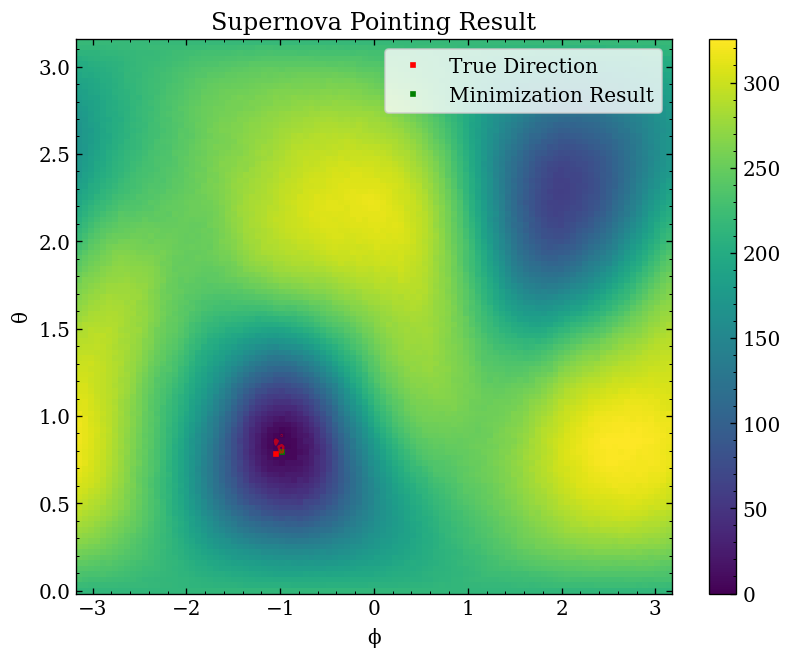

CPU times: user 995 ms, sys: 774 ms, total: 1.77 s
Wall time: 7.46 s


In [55]:
%%time
import scipy.stats as st
confusion_matrix = np.array([[0.86, 0.2], [0.04, 0.8]])
expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
print(expected_counts)
SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                               synthetic=True, 
                               with_radio=True, 
                               sn_dir= np.array([np.pi/4, -np.pi/3]),
                               expected_counts=expected_counts, 
                               pre_rotated_files=False)
print(SN_pointer.is_pure)

def loss_func(x):
    return SN_pointer.loss(x)


res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
# print(res[0])
# print(SN_pointer.truth_dir)
# print(f"Loss = {loss_func(SN_pointer.truth_dir)}")
# print(res)
# details(SN_pointer, res)

# result [x0, fval, grid, jout]
pointer = SN_pointer
(x0, fval, grid, jout) = res
plt.figure(figsize=(8, 6), dpi=120)
# plt.imshow(jout, extent=[-np.pi, np.pi, np.pi, 0],
#            origin='upper', aspect='auto')
jout *= -1
min_likelihood = np.max(jout)
conf_region = 2 * (min_likelihood - jout)
# print(conf_region)

# conf_region = 1-st.chi2.cdf(conf_region, 2)
plt.pcolormesh(grid[1], grid[0], conf_region)
plt.plot(pointer.truth_dir[1], pointer.truth_dir[0],
         'rs', label="True Direction", markersize=2)
plt.plot(x0[1], x0[0], 'gs', label='Minimization Result', markersize=2)
plt.colorbar()
plt.legend()
plt.title('Supernova Pointing Result')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')
dot = sphere_to_xyz(pointer.truth_dir).dot(sphere_to_xyz(x0))
plt.contour(grid[1], grid[0], conf_region, levels=[0.99],colors='r', alpha=0.6)
plt.show()
# return degree deviation between minimization and truth
# return np.arccos(dot) * 180 / np.pi


In [50]:
np.nanmax(st.chi2.cdf(conf_region, 1)[conf_region!=0])

0.6494631712810809

In [38]:
with open("SN_minimization_result.pkl", 'wb') as f:
    pickle.dump((pointer.truth_dir[0], pointer.truth_dir[1], grid[1], grid[0], jout), f)


Text(0, 0.5, '$\\theta$')

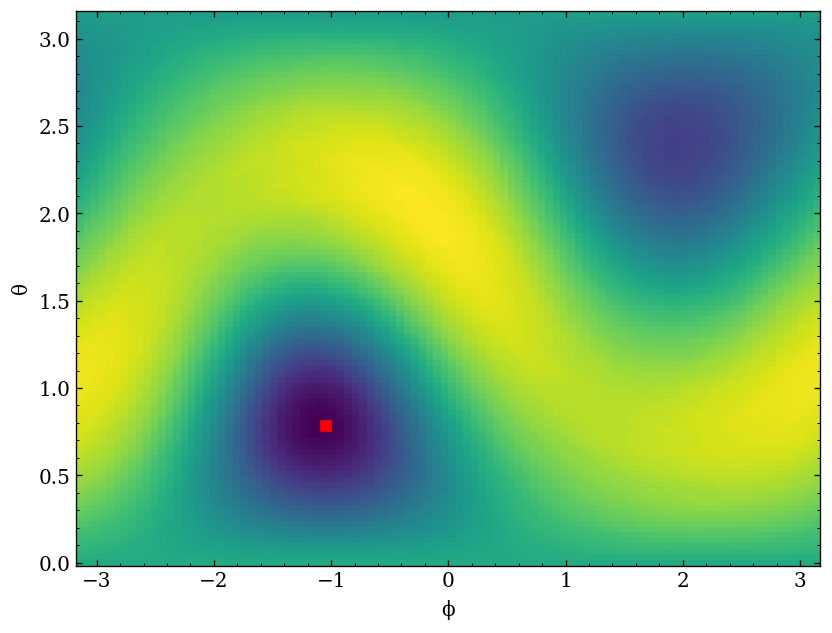

In [42]:
theta, phi, grid_x, grid_y, jout = (pointer.truth_dir[0], pointer.truth_dir[1], grid[1], grid[0], jout)
plt.pcolormesh(grid_x, grid_y, jout) # Likelihood score
plt.plot(phi, theta, 'rs') # Truth direction
plt.xlabel('$\\phi$')
plt.ylabel('$\\theta$')

In [30]:
%%time
TRIALS=10000

errors = []
config = (
    1.0, 0.0, # Confusion matrix elements
    326, 3452, # expected counts
    5
)

pool = mp.Pool(processes=mp.cpu_count())
errors = pool.starmap(run_reco, [config for _ in range(TRIALS)])
pool.close()
errors = np.asarray(errors)
print(np.quantile(errors, 0.68))

3.525130105678498
CPU times: user 452 ms, sys: 237 ms, total: 689 ms
Wall time: 3min 59s


In [31]:
%%time
TRIALS=10000

errors_real = []
config = (
    0.86, 0.04, # Confusion matrix elements
    326, 3452, # expected counts,
    5,
)

pool = mp.Pool(processes=mp.cpu_count())
errors_real = pool.starmap(run_reco, [config for _ in range(TRIALS)])
pool.close()
errors_real = np.asarray(errors_real)
print(np.quantile(errors_real, 0.68))

4.339235914079419
CPU times: user 510 ms, sys: 319 ms, total: 829 ms
Wall time: 5min 47s


[0.9971335545893836, 0.9975, 0.998, 0.9984999999999999, 0.999, 0.9995, 1.0]
[0.0602 0.0665 0.0877 0.1167 0.1546 0.2094]


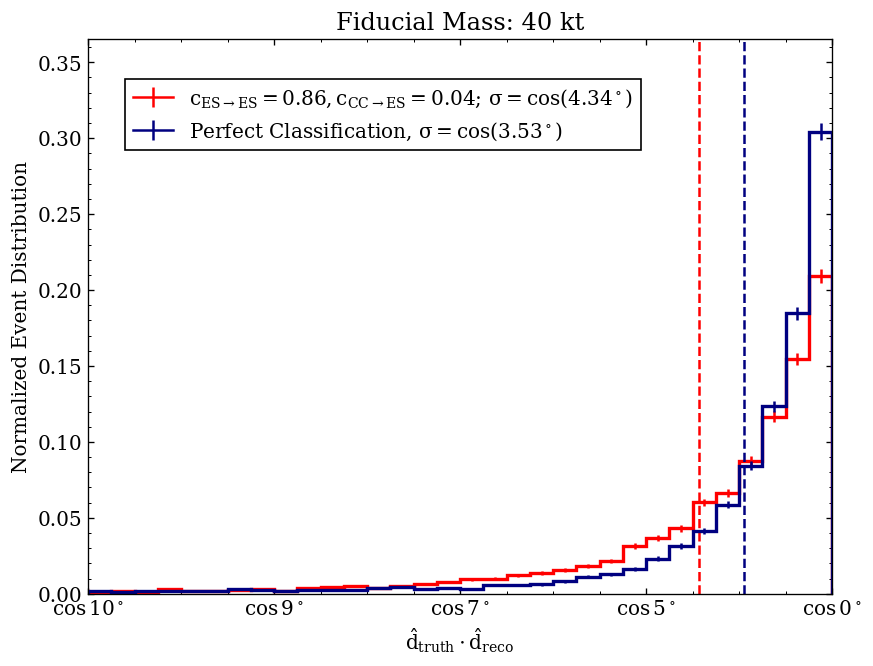

In [34]:
# %%notify
TRIALS=10000

def find_bin_id(binedges, value):
    return np.searchsorted(binedges, value)-1
cos_errors = np.cos(errors*np.pi/180)
cos_errors_real = np.cos(errors_real*np.pi/180)
sigma = np.quantile(cos_errors, 1-0.68)
# sigma = np.arccos(sigma)*180/np.pi
sigma_real = np.quantile(cos_errors_real, 1-0.68)
# sigma_real = np.arccos(sigma_real)*180/np.pi

# y, x = np.histogram(errors[errors < 90], bins=25, range=(0, 25))
# plt.errorbar(0.5*(x[:-1] + x[1:]), y, fmt='k.', yerr=np.sqrt(y), markersize=0)
# fig, ax = plt.subplots()
NBINS=100
color='r'
content, binedge, _ = plt.hist(cos_errors_real, histtype='step', range=(0.95, 1),
                               color=color, linewidth=2, bins=NBINS, log=False, weights=TRIALS * [1/TRIALS])

plt.errorbar((binedge[:-1] + binedge[1:])/2, content, yerr=np.sqrt(content)/np.sqrt(TRIALS), color=color, fmt='.', markersize=0, )
plt.errorbar([], [], yerr=[], c=color, label=f'$c_{{ES\\rightarrow ES}} = 0.86, c_{{CC\\rightarrow ES}} = 0.04$; $\\sigma=cos({180/np.pi*np.arccos(sigma_real):.2f}^\\circ$)')
plt.vlines(sigma_real, 0, 5000, color=color, linestyles='dashed')
print([sigma_real, *binedge[find_bin_id(binedge, sigma_real)+1:]])
print(content[find_bin_id(binedge, sigma_real):])


color='navy'
content, binedge, _ = plt.hist(cos_errors, histtype='step', range=(0.95, 1),
                               color=color, linewidth=2, bins=NBINS, log=False, weights=TRIALS * [1/TRIALS])
plt.errorbar((binedge[:-1] + binedge[1:])/2, content, yerr=np.sqrt(content)/np.sqrt(TRIALS), color=color, fmt='.', markersize=0)
plt.errorbar([], [], yerr=[], c=color, label=f'Perfect Classification, $\\sigma=cos({180/np.pi*np.arccos(sigma):.2f}^\\circ$)')
plt.vlines(sigma, 0, 5000, color=color, linestyles='dashed')

xmin = 0.984
xmax = 1.0
plt.xlim(xmin, xmax)
plt.ylim(0, np.max(content)*1.2)
# plt.title(f"Angle between reco and truth SN direction (ES + radiological)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
# plt.xlabel("Degrees")

# plt.fill_between([sigma, 1.0], [1e6, 1e6], color='lightgrey')
ticks = np.linspace(xmin, xmax, 5, endpoint=True)
angles = np.arccos(ticks) * 180 / np.pi
labels = [f'$\\cos{a:.0f}^\\circ$' for a in angles]
plt.xticks(ticks, labels)
leg = plt.legend(fancybox=False, loc=(0.05, 0.8), framealpha=1.0)
leg.get_frame().set_edgecolor('k')

plt.ylabel('Normalized Event Distribution')
plt.xlabel(r'$\hat{d}_{truth} \cdot \hat{d}_{reco}$')
plt.title("Fiducial Mass: 40 kt")

# plt.title(f"$\\sigma = {sigma:.4f}$")
plt.savefig('/media/linux_store/hep/dune_pointing_paper/plots/pointres_40kt.eps', format='eps')

In [13]:
%%time 
### Reconstruction performance as a function of energy cut
import multiprocessing as mp
thresholds = np.array([0, 5, 10])
TRIALS=1000
hists = []
def run_trial(th):
        confusion_matrix = np.array([[0.86, 0.5], [0.04, 0.5]])
        expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
        SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                   synthetic=True, with_radio=True, expected_counts=expected_counts, poisson_count=True,
                                      pre_rotated_files=False)
        res = brute(SN_pointer.loss, ([0, np.pi], [0, 2*np.pi]), args=(1e-4, th),
                    Ns=10, full_output=False, workers=1, finish=fmin)
        return (error(SN_pointer, res))
#     errors = np.asarray(errors)
#     hists.append(errors)
    
pool = mp.Pool(processes=mp.cpu_count())
errors = (pool.map(run_trial, np.ones(TRIALS) * 5))
pool.close()

CPU times: user 214 ms, sys: 134 ms, total: 348 ms
Wall time: 23.8 s


In [14]:
82*0.05

4.1000000000000005

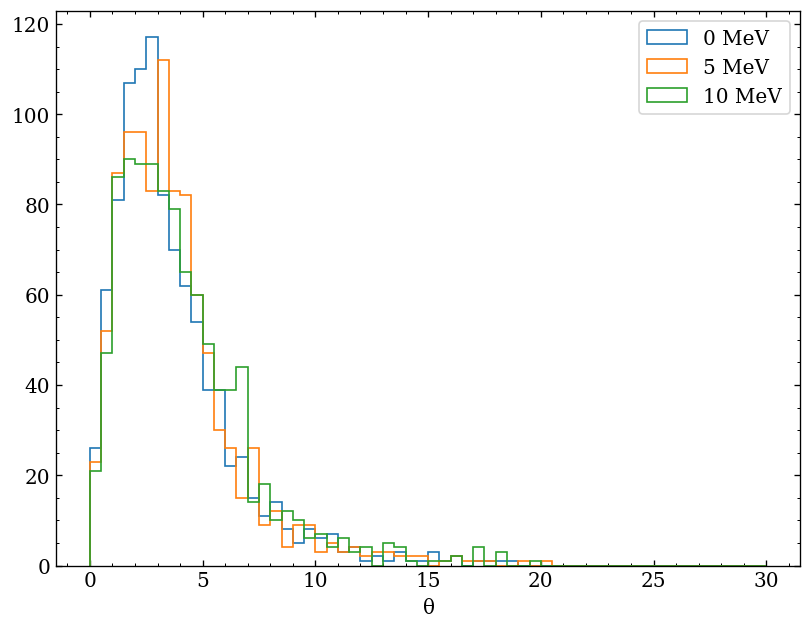

In [19]:
for t, h in zip(thresholds, hists):
    plt.hist(h, bins=60, range=(0, 30), label=f'{t} MeV', histtype='step')
plt.xlabel("$\\theta$")
plt.legend()


In [82]:
binedge.shape

(151,)

In [9]:
TRIALS=1000

quantiles_list = []
gridpoints = np.arange(0.1, 1.1, 0.1)
for a in gridpoints:
    for b in gridpoints:
        errors = []
        for _ in trange(TRIALS, desc=f"{a = :.2f}, {b = :.2f}"):
            confusion_matrix = np.array([[a, 0.5], [b, 0.5]])
            expected_counts = get_expected_counts([326, 3455], confusion_matrix, channel_id_list=[0])
            SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                       synthetic=True, with_radio=True, expected_counts=expected_counts)
            def loss_func(x):
                return SN_pointer.loss(x)
            res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=10, 
                        full_output=False, workers=10, finish=fmin)
            errors.append(error(SN_pointer, res))
        quantiles_list.append(np.array([a, b, np.quantile(errors, 0.68)]))

with open('../../../data/classifier_matrix.pkl', 'wb') as f:
    pickle.dump(quantiles_list, f)

a = 0.10, b = 0.10:   5%|███▌                                                                 | 52/1000 [00:17<05:10,  3.06it/s]


KeyboardInterrupt: 

In [3]:
import pickle
with open('../../../data/classifier_matrix.pkl', 'rb') as f:
    quantiles_list = pickle.load(f)
# gridpoints = np.arange(0.1, 1.1, 0.1)
gridpoints = np.linspace(0, 1, 21, endpoint=True)[1:]

from matplotlib.colors import LogNorm

quantiles_list = np.array(quantiles_list)
x = quantiles_list[:, 0]
y = quantiles_list[:, 1]
z = quantiles_list[:, 2]
# x=np.unique(x)
# y=np.unique(y)
dim = len(gridpoints)
X = x.reshape(dim,dim)
Y = y.reshape(dim,dim)

Z=z.reshape(dim, dim)
print(np.min(Z))

pcol=plt.pcolormesh(X, Y, Z, cmap='viridis_r', vmin=0)
pcol.set_edgecolor('face')
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Pointing Resolution (deg)')

# plt.title('68% Quantiles')
plt.xlabel(r'ES true positives')
plt.ylabel(r'CC False Negatives')
plt.contour(X, Y, Z, [10, 15, 20, 45, 60])
# plt.savefig('/media/linux_store/hep/dune_pointing_paper/plots/mixing.eps', format='eps')
plt.show()


ValueError: cannot reshape array of size 420 into shape (20,20)

## Plot Classifier Map using pickles

6.2516593523060715


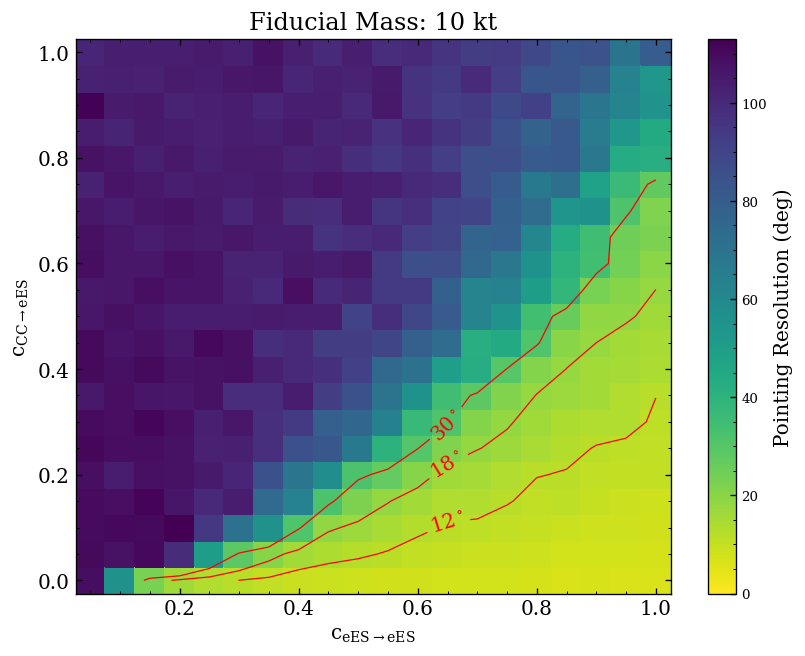

In [16]:
with open('../../../data/classifier_matrix.pkl', 'rb') as f:
    quantiles_list = pickle.load(f)

# with open('../../../data/classifier_matrix_zeros.pkl', 'rb') as f:
#     quantiles_list_zeros = pickle.load(f)
# # gridpoints = np.arange(0.1, 1.1, 0.1)
# quantiles_list = np.array([*quantiles_list, *quantiles_list_zeros])

quantiles_list = np.asarray(quantiles_list)
x_data = quantiles_list[:, 0]
y_data = quantiles_list[:, 1]
z_data = quantiles_list[:, 2]
print(np.array(z_data).min())
# Sort coordinates and reshape in grid
idx = np.lexsort((y_data, x_data)).reshape(np.unique(x_data).size, np.unique(y_data).size)
# Plot
pcol=plt.pcolormesh(x_data[idx], y_data[idx], z_data[idx], cmap='viridis_r', vmin=0)
pcol.set_edgecolor('face')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Pointing Resolution (deg)')

# plt.title('68% Quantiles')
plt.xlabel(r'$c_{eES\rightarrow eES}$')
plt.ylabel(r'$c_{CC\rightarrow eES}$')
levels = [6, 12, 18, 30]

fmt = {}
CS = plt.contour(x_data[idx], y_data[idx], z_data[idx], levels, colors='red', linestyles='solid', linewidths=0.75)
# plt.plot(0.86, 0.04, 'rs', label=f'$\it{{E. Conley\ (2020)}}$')
for l, s in zip(CS.levels, levels):
    fmt[l] = f'${s}^\circ$'
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12)
# plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
# leg = plt.legend(fancybox=False, loc='upper left')
# leg.get_frame().set_edgecolor('k')
plt.title("Fiducial Mass: 10 kt")
plt.savefig('/media/linux_store/hep/dune_pointing_paper/plots/mixing_10kt.eps', format='eps')
plt.show()


3.558482619552029


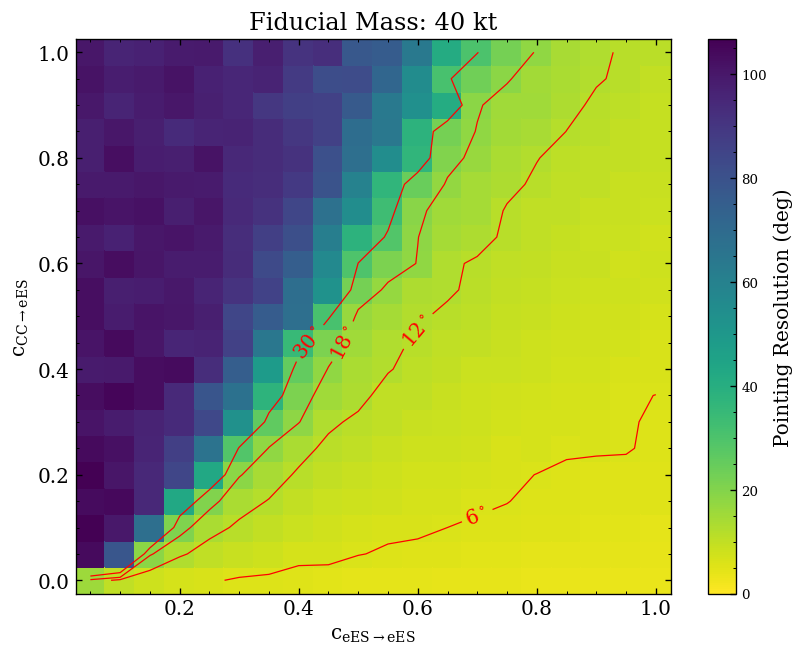

In [18]:
with open('../../../data/classifier_matrix_40kt.pkl', 'rb') as f:
    quantiles_list = pickle.load(f)

# with open('../../../data/classifier_matrix_zeros.pkl', 'rb') as f:
#     quantiles_list_zeros = pickle.load(f)
# # gridpoints = np.arange(0.1, 1.1, 0.1)
# quantiles_list = np.array([*quantiles_list, *quantiles_list_zeros])

quantiles_list = np.asarray(quantiles_list)
x_data = quantiles_list[:, 0]
y_data = quantiles_list[:, 1]
z_data = quantiles_list[:, 2]
print(np.array(z_data).min())
# Sort coordinates and reshape in grid
idx = np.lexsort((y_data, x_data)).reshape(np.unique(x_data).size, np.unique(y_data).size)
# Plot
pcol=plt.pcolormesh(x_data[idx], y_data[idx], z_data[idx], cmap='viridis_r', vmin=0)
pcol.set_edgecolor('face')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Pointing Resolution (deg)')

# plt.title('68% Quantiles')
plt.xlabel(r'$c_{eES\rightarrow eES}$')
plt.ylabel(r'$c_{CC\rightarrow eES}$')
levels = [6, 12, 18, 30]

fmt = {}
CS = plt.contour(x_data[idx], y_data[idx], z_data[idx], levels, colors='red', linestyles='solid', linewidths=0.75)
# plt.plot(0.86, 0.04, 'rs', label=f'$\it{{E. Conley\ (2020)}}$')
for l, s in zip(CS.levels, levels):
    fmt[l] = f'${s}^\circ$'
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12)
# plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
# leg = plt.legend(fancybox=False, loc='upper left')
# leg.get_frame().set_edgecolor('k')
plt.title("Fiducial Mass: 40 kt")
plt.savefig('/media/linux_store/hep/dune_pointing_paper/plots/mixing_40kt.eps', format='eps')
plt.show()


In [6]:
TRIALS=10

distance = [1, 5, 10, 20, 50]
quantiles_list = []
# gridpoints = np.arange(0.1, 1.1, 0.1)
for d in distance:
    errors = []
    for _ in trange(TRIALS, desc=f"Distance = {d} kpc"):
        confusion_matrix = np.array([[1, 0.5], [0, 0.5]])
        scaling_factor = (d/10)**(-2)
        expected_counts = get_expected_counts([int(326*scaling_factor), int(3455*scaling_factor)], confusion_matrix, channel_id_list=[0])
        SN_pointer = SupernovaPointing([ES_numeric, CC_numeric], [ES_event_pool, CC_event_pool],
                                   synthetic=True, with_radio=True, expected_counts=expected_counts)
        def loss_func(x):
            return SN_pointer.loss(x)
        res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=10, 
                    full_output=False, workers=10, finish=fmin)
        errors.append(error(SN_pointer, res))
    quantiles_list.append(np.quantile(errors, 0.68))


Distance = 50 kpc: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.57it/s]


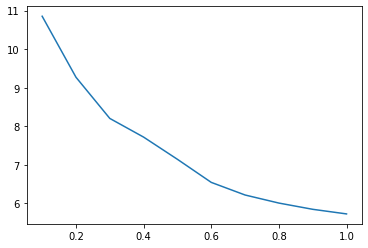

In [22]:
efficiency_quantiles_list = np.array(efficiency_quantiles_list)
plt.plot(efficiency_quantiles_list[:, 0], efficiency_quantiles_list[:, 1])
plt.show()